In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import scipy
from scipy.interpolate import griddata
import geopandas
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import nctoolkit 
import os
import glob
from datetime import datetime
from dateutil import tz

nctoolkit is using Climate Data Operators version 2.1.1


In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
import timeit
tic=timeit.default_timer()
# Do Stuff
toc=timeit.default_timer()
toc - tic #elapsed time in seconds

4.95067797601223e-05

# meshgrid

In [21]:
# interpolate ch13 BT data onto lat lon mesh grid
# specify file path
# mypath = "/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/"
mypath = "/g/data/gy85/Himawari8_AusGeo1-0-3/L2/summer_2015-2016/201602"
files = [os.path.join(root, f) for root, _, files in os.walk(mypath)
         for f in files
         if f.startswith('geocatL2.HIMAWARI-8.2016') and f.endswith('.nc')]
files.sort() # order files 

In [6]:
jan01 = files[0:24]

In [36]:
ds = xr.open_dataset(files[0],engine="h5netcdf")
ds

<xarray.Dataset>
Dimensions:                                         (lines: 5500,
                                                     elements: 5500,
                                                     byte_segmentsACHA_mode_8_Cloud_Height_Qpi: 1,
                                                     byte_segmentsenterprise_cldphase_10_11_13_14_15_Cldphase_Qf: 1,
                                                     byte_segmentsgoesr_fog_bridge_Fog_Qf: 1,
                                                     byte_segmentsgoesr_fog_bridge_Fog_Qpi: 1)
Dimensions without coordinates: lines, elements,
                                byte_segmentsACHA_mode_8_Cloud_Height_Qpi,
                                byte_segmentsenterprise_cldphase_10_11_13_14_15_Cldphase_Qf,
                                byte_segmentsgoesr_fog_bridge_Fog_Qf,
                                byte_segmentsgoesr_fog_bridge_Fog_Qpi
Data variables: (12/41)
    ACHA_mode_8_Cloud_Height_QF                     (lines, elements) float32 ...
    ACHA_mode_8_Cloud_Height_Qpi                    (lines, elements, byte_segmentsACHA_mode_8_Cloud_Height_Qpi) float32 ...
    ACHA_mode_8_cloud_optical_depth_vis             (lines, elements) float32 ...
    ACHA_mode_8_cloud_particle_effective_radius     (lines, elements) float32 ...
    ACHA_mode_8_cloud_top_height                    (lines, elements) float32 ...
    ACHA_mode_8_cloud_top_pressure                  (lines, elements) float32 ...
    ...                                              ...
    pixel_latitude                                  (lines, elements) float32 ...
    pixel_longitude                                 (lines, elements) float32 ...
    pixel_relative_azimuth_angle                    (lines, elements) float32 ...
    pixel_satellite_zenith_angle                    (lines, elements) float32 ...
    pixel_solar_zenith_angle                        (lines, elements) float32 ...
    pixel_surface_type                              (lines, elements) float32 ...
Attributes: (12/100)
    Ancillary_Data_Directory:                                  ./data/
    Ancillary_Package_Version:                                 NA
    Conventions:                                               CF-1.6, ACDD-1.3
    Default_Aerosol_Mask_Algorithm_Index:                      -999
    Default_Aerosol_Mask_Name:                                 NA
    Default_Ash_Dust_Detection_Algorithm_Index:                -999
    ...                                                        ...
    references:                                                Lopez-Bravo, L...
    source:                                                    Advance Himawa...
    summary:                                                   Satellite obse...
    time_coverage_end:                                         2020-03-31
    time_coverage_start:                                       2015-11-01
    title:                                                     Himawari-8 Geo...

In [46]:
BT_data_T

[array([211.2656 ,   0.     ,   0.     ,   0.     ,   0.     , 209.55656,
        210.50142,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
        210.23285,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
        237.48466,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
        289.5468 , 288.7997 , 295.23788, 298.72678,   0.     , 297.58173,
          0.     ,   0.     ,   0.     , 301.45392, 300.83377, 300.2063 ,
          0.     , 298.90012, 300.9119 ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     ,   0.     ,   0.     ,   0.     ,   0.     ,   0.     ,
          0.     , 303.59265,   0.    

In [45]:
##### create empty arrays to append data
BT_data_T = []
BT_data_C = []
BT_data_W = []
filenumber = []
times = []
output_df = []

# create for loop to generate data arrays
for file in files[48:168]:   #9/1-14/1=[181:275] #19/1-31/1=[393:671] #31st-5th/6th=[670:786/811] #9/2-14/2=[881:1001]
    # time how long it takes to loop
    tic=timeit.default_timer()

    # read file 
        #ds = nc.Dataset(fp[0],"r") # using nc # both methods work - check which is faster
        # can I specify in xr open_dataset which variables to look at - maybe increase efficiency?
        # https://stackoverflow.com/questions/35422862/speeding-up-reading-of-very-large-netcdf-file-in-python
    ds = xr.open_dataset(file,engine="h5netcdf")#,chunks='auto') 
    
    #assign file variable contents to python variables and reshape - making smaller domain decreased compute time significantly
        # used iris cubes (below) to visualize data in order to choose domain size
    ch13bt_data = ds['ACHA_mode_8_cloud_top_temperature'][:3299,33:4124].values #[1910:2170,2800:3400].values##[1700:2300,2800:3500].values#for valid points=[:3299,33:4124]
    ch13bt_reshape = ch13bt_data.reshape(13496209) # with entire array = 30250000; for valid points=13496209
    ch13bt_reshape[np.isnan(ch13bt_reshape)] = 0    
    lon2d = ds['pixel_longitude'][:3299,33:4124].values
    lon1d = lon2d.reshape(13496209)
    lon1d[np.isnan(lon1d)] = 0
    lat2d = ds['pixel_latitude'][:3299,33:4124].values
    lat1d = lat2d.reshape(13496209)
    lat1d[np.isnan(lat1d)] = 0
    
    # create meshgrid for interpolation
    res = 0.1 #0.18
    grid_x = np.arange(140, 154, res)#154, res)
    grid_y = np.arange(-22, -11, res)#-22, -11, res)
    grid_y = np.flipud(grid_y)
    xi,yi = np.meshgrid(grid_x,grid_y)
    
    # interpolate channel 13 brightness temperature values onto x,y grid
    CTP = griddata((lon1d,lat1d), ch13bt_reshape, (xi, yi), method='nearest') ##### return= CTP[lat:lon]    
    # BT_data_T.append(CTP[83,:]) # 840 for res=0.01 # 167 for res=0.05 #83 for res=0.1 
    BT_data_C.append(CTP[57,:]) #581 #115 #57
    BT_data_W.append(CTP[52,:]) #528 #105 #52
    BT_data_T.append(CTP[8,:]) # this is for looking at cape grenville for Whlex
    
    # append time data
    fn = os.path.basename(file).split('/')[-1]
    times.append(fn[20:32])
    
    # compute time data
    toc=timeit.default_timer()
    time_elapsed = toc - tic
    #print(time_elapsed)
    filenumber.append(time_elapsed)

# Add topography

In [6]:
# open ds
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds = ds_full.sel(x=slice(140,150),y=slice(-22,-11))

In [7]:
lon = np.linspace(min(ds['x'].data), max(ds['x'].data), len(ds['x'].data))
lat = np.linspace(min(ds['y'].data), max(ds['y'].data), len(ds['y'].data))

lon, lat = np.meshgrid(lon, lat)
dem = ds['z'].data

# Plot hovmoller

In [51]:
# define function to plot hovmoller
def plot_hovmoller(level_data,cbar_units):#,y_axis_step,yticks): #file_number
     # Assign (x) longitude values for chosen domain (selected in meshgrid creation)
    lon = xi[0]
    # Assign (y) times
    time = times #np.arange(0,file_number,1)        
    # Assign (z) variable - BT data
    variable_data_T = BT_data_T # lat -19.41
    variable_data_C = BT_data_C # lat -16.82
    variable_data_W = BT_data_W # lat -16.29
    
    # create plot
    fig, ax = plt.subplots(1,3,figsize=(18,10))
    fig.patch.set_facecolor('white')

 #   gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='-')

    ax[0].set_xlim(140,147) #looking at cape grenville; T=()143,150
    ax[1].set_xlim(143,149)
    ax[2].set_xlim(147,153)
    
    # Set some titles
    ax[0].set_title('Townsville (lat=-19.4)', loc='left', fontsize=20,fontweight=0.9)
    ax[1].set_title('Cairns (lat=-16.82)', loc='left', fontsize=20,fontweight=0.9)
    ax[2].set_title('Willis Island (lat=-16.29)', loc='left', fontsize=20,fontweight=0.9)
   # fig.figure.suptitle(suptitle,fontsize=30) #,x=0.2,y=0.98,

    # Plot of chosen variable averaged over latitude and slightly smoothed
    levels = level_data
    cf_T = ax[0].contourf(lon,time,variable_data_T,levels=levels,cmap="binary")
    cf_C = ax[1].contourf(lon,time,variable_data_C,levels=levels,cmap="binary")
    cf_W = ax[2].contourf(lon,time,variable_data_W,levels=levels,cmap="binary")              
                    
    # cbar and cbar label                
    cbar_W = plt.colorbar(cf_T, ax=ax[2],orientation='vertical', pad=0.04, aspect=30, extendrect=True,
                         ticks=[180,190,200,210,220,230,240,250,260,270,280,290,300,310,320])
    cbar_W.set_label(cbar_units,fontsize=15)
    
    # plot vertical lines to represent coastlines
    # ax[0].axvline(147.5,color='blue',alpha=0.2,linestyle='--')
    ax[1].axvline(145.75,color='blue',alpha=0.2,linestyle='--')
    
    # plot locations of radars
    # ax[0].axvline(146.55,color='k',alpha=0.5,linestyle='-.')
    ax[1].axvline(145.68,color='k',alpha=0.5,linestyle='-.')
    ax[2].axvline(149.96,color='k',alpha=0.5,linestyle='-.')
    
    # plot horizontal gridlines
    ax[0].grid(visible=None, which='major', axis='y',alpha=0.5)
    ax[1].grid(visible=None, which='major', axis='y',alpha=0.5)
    ax[2].grid(visible=None, which='major', axis='y',alpha=0.5)

   # yticks_T = np.arange(0,file_number,y_axis_step)            
    ax[0].set_yticks(np.arange(0,120,1))#yticks_T)
    ax[1].set_yticks(np.arange(0,120,1))
    ax[2].set_yticks(np.arange(0,120,1))
    #y_tick_labels_T = yticks
    ax[0].set_yticklabels(times)#y_tick_labels_T)
    ax[0].locator_params(axis='y', nbins=5)
    ax[1].set(yticklabels=[])
    ax[1].locator_params(axis='y', nbins=5)
    ax[2].set(yticklabels=[])
    ax[2].locator_params(axis='y', nbins=5)
                    
    ax[0].set_xlabel("Longitude",fontsize=15)
    ax[1].set_xlabel("Longitude",fontsize=15)
    ax[2].set_xlabel("Longitude",fontsize=15)
    ax[0].set_ylabel("UTC (date.time)",fontsize=20)            
                    
    #fig.tight_layout()
    plt.show()
    return

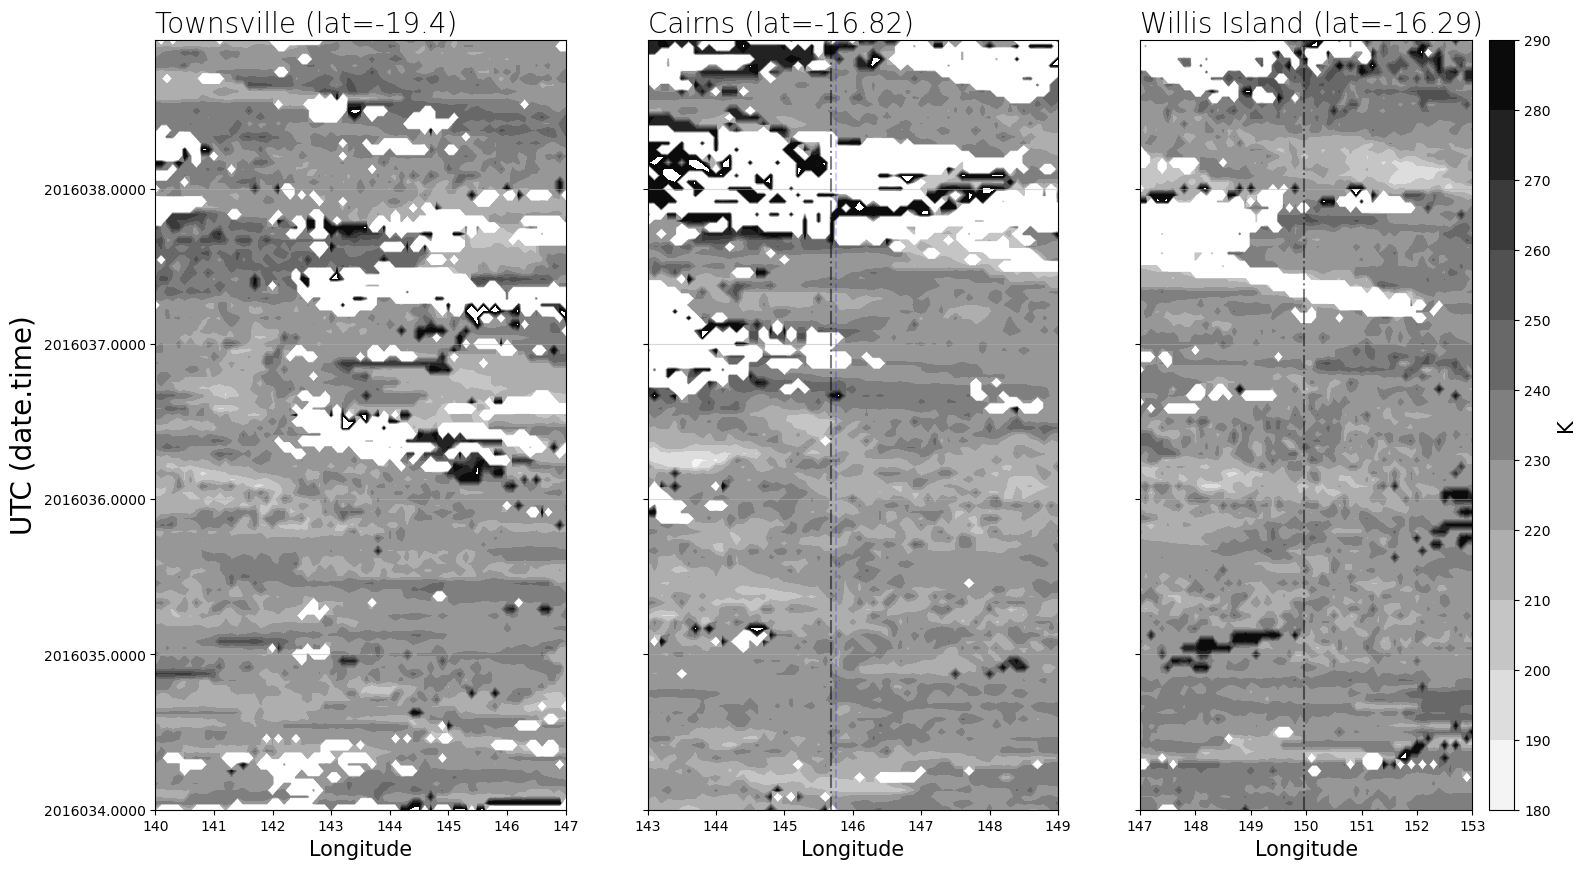

In [54]:
plot_hovmoller([180,190,200,210,220,230,240,250,260,270,280,290],"K")

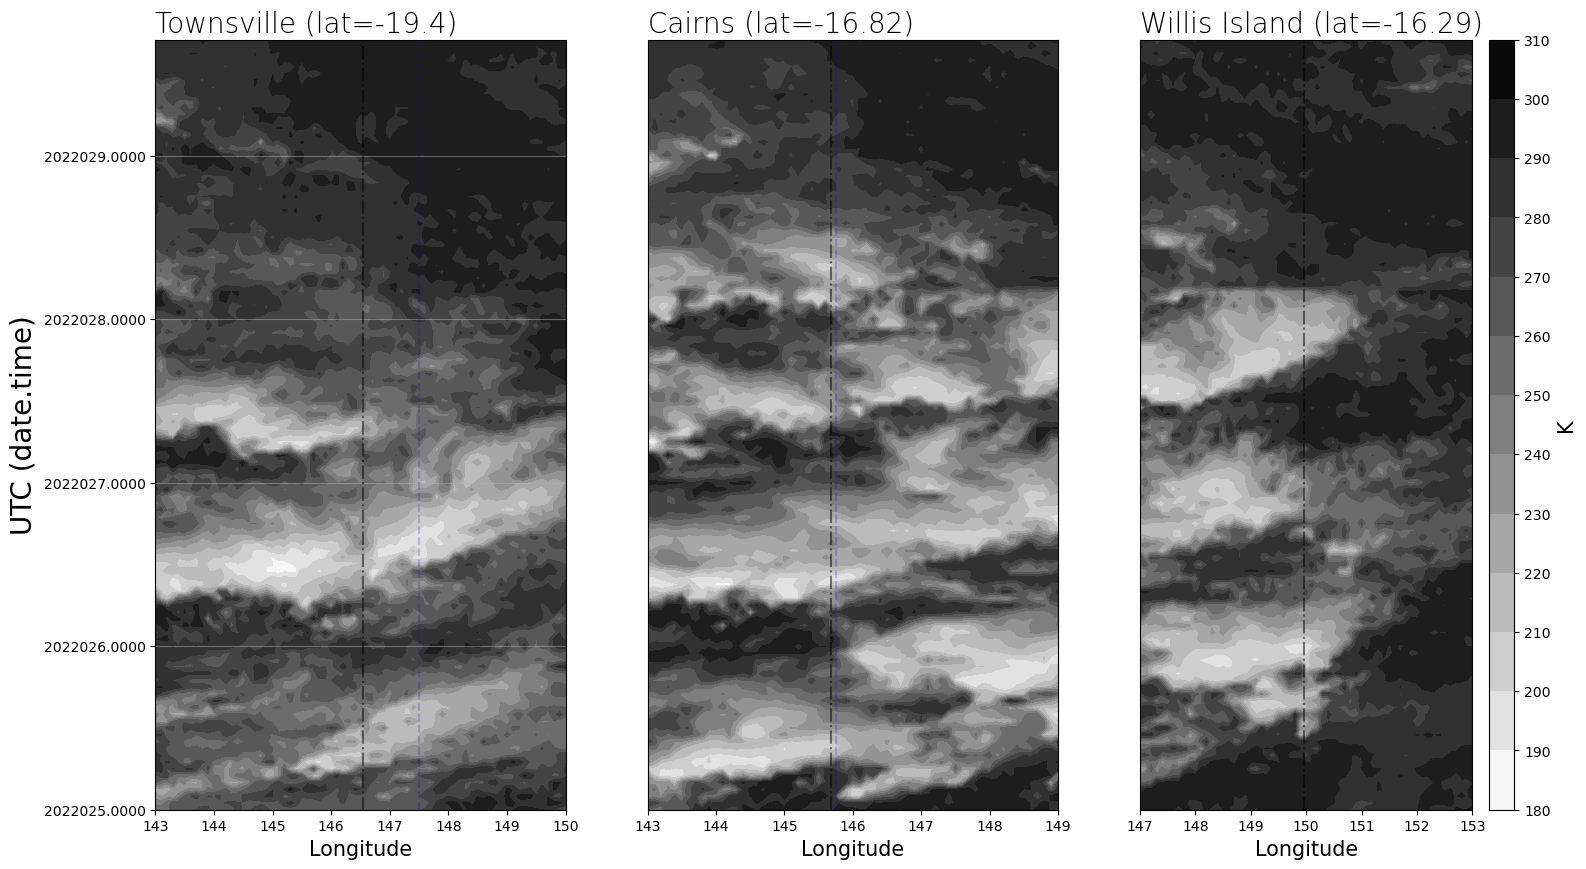

In [45]:
plot_hovmoller(116,[180,190,200,210,220,230,240,250,260,270,280,290,300,310],
               "K",24,[times[0],times[24],times[48],times[70],times[90]])
# times are wrong - from missing data files

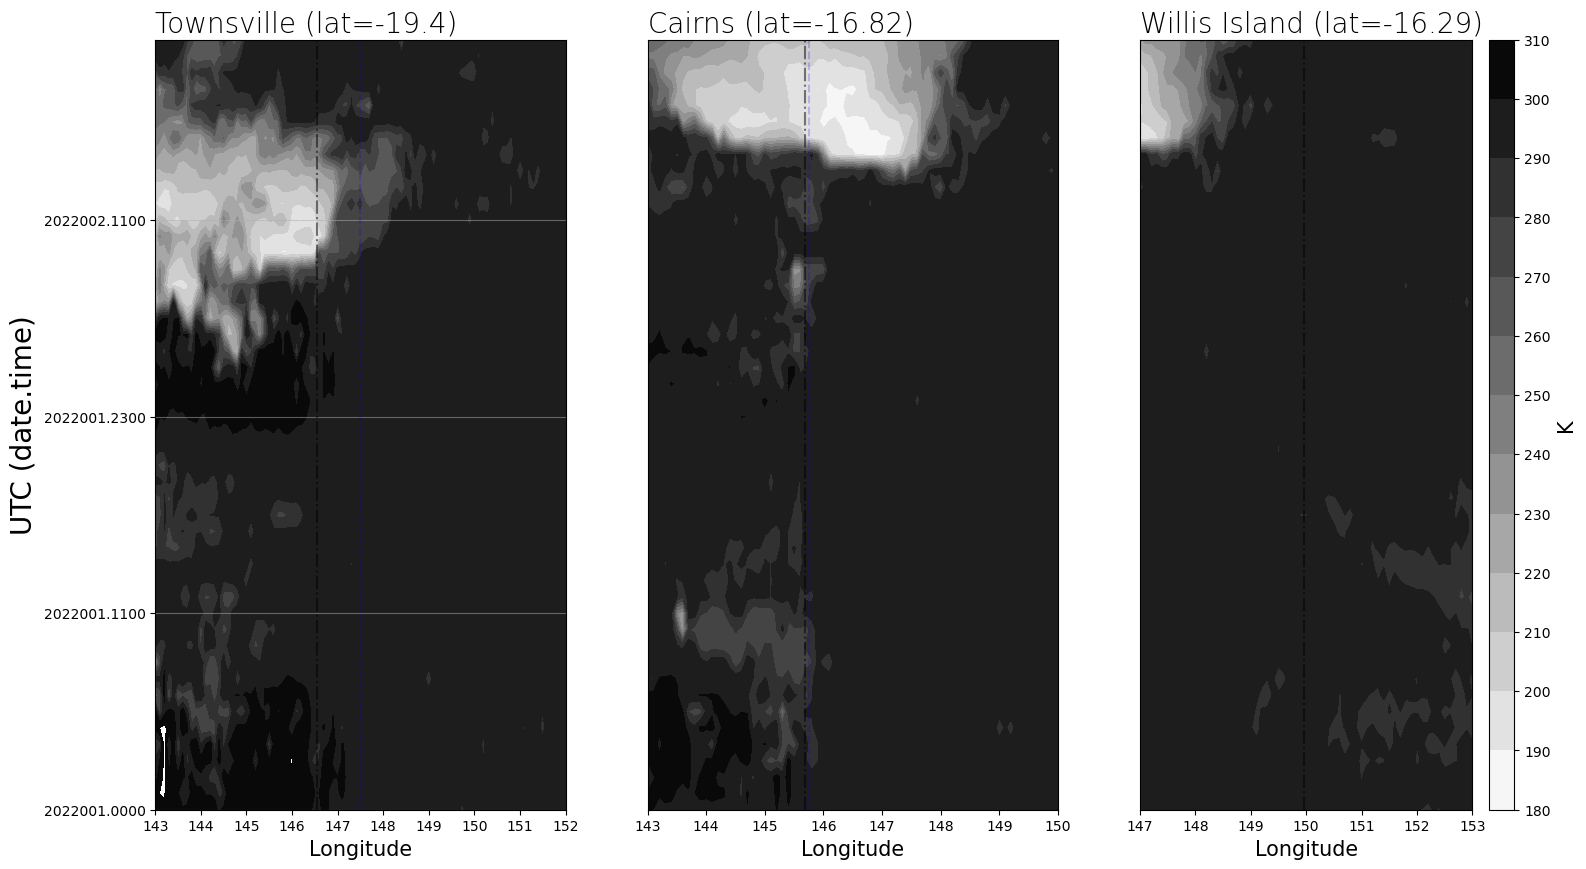

In [8]:
#plot_hovmoller(file_number,level_data,cbar_units,y_axis_step,yticks): 
plot_hovmoller(48,[180,190,200,210,220,230,240,250,260,270,280,290,300,310],
               "K",12,[times[0],times[12],times[24],times[36]])

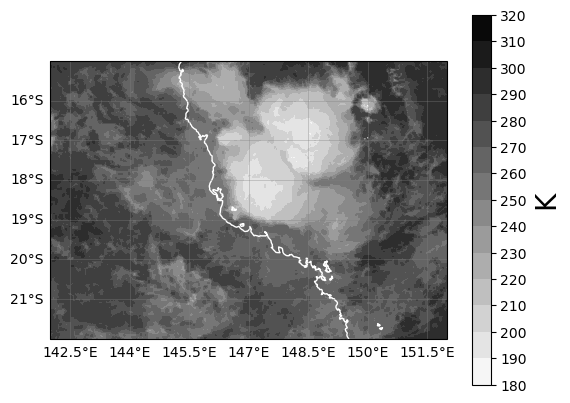

In [154]:
#### create snapshot latlong plot
ax = plt.axes(projection=ccrs.PlateCarree())
levels = [180,190,200,210,220,230,240,250,260,270,280,290,300,310,320]
cs = ax.contourf(xi,yi,CTP,levels=levels,cmap="binary")
cbar = plt.colorbar(cs,aspect=20,orientation='vertical',ax=ax,
                    ticks=[180,190,200,210,220,230,240,250,260,270,280,290,300,310,320])
cbar.set_label('K',fontsize=20) 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
gl.top_labels = False
gl.right_labels = False
ax.set_xlim(142,152)
ax.set_ylim(-22,-15)
ax.coastlines(color="white")

# iris

https://scitools-iris.readthedocs.io/en/latest/userguide/plotting_a_cube.html

In [5]:
import iris
import iris.plot as iplt
# specify filenames
filename = ['/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2022025.050000.FLDK.R20.nc']
            #'/g/data/v46/lb5963/HIMAWARI/08_V46_SUMM_2021-22/L1/geocatL1.HIMAWARI-8.2022001.060000.FLDK.R20.nc']
# load iris cubes, specifying the retrieval variables for efficiency
cube = iris.load(filename,["pixel_latitude","pixel_longitude","himawari_8_ahi_channel_13_brightness_temperature"])

2


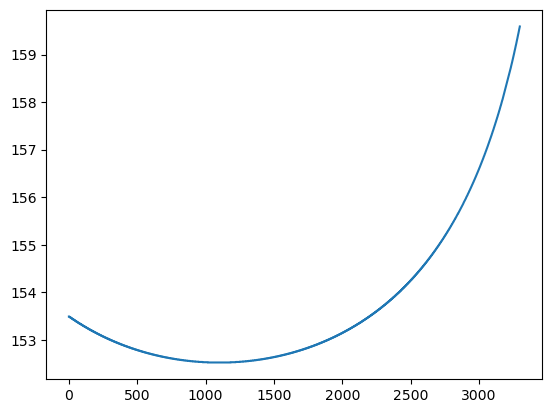

(260,)

In [28]:
#print(str(cube)) # dir(cube) and help(cube) give info on manipulation
ch13bt = cube[2]
lat = cube[0]
lon = cube[1]
#print(ch13bt.units)
#print(lat.long_name)
#print(lon.standard_name)
#print(lat.shape)
#print(ch13bt.coords)
print(ch13bt.ndim)
latdata = lat.data
londata = lon.data
btdata = ch13bt.data

#latt = lat[1910:2170,2800:3400] #[:3300,33:4124] for all valid points - smaller domain = [1700:2300,2800:3500]
#iplt.plot(latt) #1700:2300,2800:3500   ##2170
#plt.show()

lonn = lon[:,3400]
#long = lon[:,:]
iplt.plot(lonn)
#iplt.plot(long)
plt.show()

#btt = ch13bt[:,33]
#iplt.plot(btt)
#plt.show()
latt.shape

# use cartopy

In [ ]:
projPC = ccrs.PlateCarree()
lonW = 144
lonE = 149
latS = -21
latN = -18
res = '110m'
lon = ds_Him8BT["pixel_longitude"].isel(Index=0)
lat = ds_Him8BT["pixel_latitude"].isel(Index=0)
clevels = range(180,300,1)

fig = plt.figure(figsize=(20, 10))
fig.tight_layout()
fig.patch.set_facecolor('white')
ax = plt.subplot(1, 1, 1, projection=projPC)
ax.set_title('Channel 13 Brightness Temperature',fontsize=25)
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='-')
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
ax.coastlines(resolution=res, color='white')
cs = ax.contourf(lon,lat,ds_Him8BT["himawari_8_ahi_channel_13_brightness_temperature"].isel(Index=0),levels=clevels,cmap="binary")
cbar = plt.colorbar(cs,aspect=25,orientation='vertical',ax=ax,ticks=[180,190,200,210,220,230,240,250,260,270,280,290,300])
cbar.set_label('K',fontsize=20) 

In [ ]:
projPC = ccrs.PlateCarree()
lonW = 140
lonE = 155
latS = -22
latN = -12
cLat = (latN + latS) / 2
cLon = (lonW + lonE) / 2
res = '50m'
lon = ds_Him8BT["pixel_longitude"]
lat = ds_Him8BT["pixel_latitude"]
clevels = range(180,300,1)

gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.2, linestyle='-')
ax.set_extent([lonW, lonE, latS, latN], crs=projPC)

In [ ]:
lat = ds_Him8BT["pixel_latitude"]
lat.values

In [ ]:
variable_data_T = ds_Him8BT["himawari_8_ahi_channel_13_brightness_temperature"].isel(lat=).sel(time=time_slice)
variable_data_T.x.values

In [ ]:
projPC = ccrs.PlateCarree()
lonW_T = 144
lonW_C = 143
lonW_W = 147
lonE_T = 149
lonE_C = 148
lonE_W = 153
lat_T = -19.4
lat_C = -16.8
lat_W = -16.3
clevels = range(180,300,1)
lon = slice(144,149)

plt.figure(figsize=(5, 3)) 
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-19.4)) 
ax.set_xlim([144, 149]) 
ax.set_ylim(-19.4) 
ax.coastlines(resolution='50m') 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')
cs = ax.contourf(lon,ds_Him8BT.Index,ds_Him8BT["himawari_8_ahi_channel_13_brightness_temperature"],levels=clevels,cmap="binary")


#ax[0].set_extent([lonW_T, lonE_T, lat_T], crs=projPC)
#ax[1].set_extent([lonW_C, lonE_C, lat_C], crs=projPC)
#ax[2].set_xlim([lonW_W, lonE_W, lat_W], crs=projPC)

#plt.axes(projection=ccrs.PlateCarree(central_longitude=-35)